# **Neural Style Transfer with InceptionV3**

### **Imports and Utilities**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from IPython.display import display as display_fn
from IPython.display import Image, clear_output

In [2]:
def tensor_to_image(tensor):
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor)


def load_img(path_to_img):
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def show_images(images, titles=[]):
  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])

    if len(image.shape) > 3:
      image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    plt.title(title)

def preprocess_image(image):
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

### **Extract Style and Content Features using InceptionV3**

In [3]:
# Choosing earlier layers for extracting style features
style_layers = ['conv2d',
                'conv2d_1',
                'conv2d_2',
                'conv2d_3',
                'conv2d_4',
                'conv2d_7',
                'conv2d_9',
                ]
content_layers = ['conv2d_88'] # Choosing deeper layer for extracting content features
content_and_style_layers = style_layers + content_layers

NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [4]:
def inception_model(layer_names):
  inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
  inception.trainable = False
  outputs = [inception.get_layer(name).output for name in layer_names]
  model = tf.keras.Model(inputs=inception.input, outputs=outputs)
  return model

inceptionv3 = inception_model(content_and_style_layers)
inceptionv3.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

### **Calculate Loss**

In [5]:
def get_style_loss(features, targets):
  style_loss = tf.reduce_mean(tf.square(features - targets))
  return style_loss

In [6]:
def get_content_loss(features, targets):
  content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
  return content_loss

In [7]:
def gram_matrix(input_tensor):
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  input_shape = tf.shape(input_tensor)
  height = input_shape[1]
  width = input_shape[2]
  num_locations = tf.cast(height * width, tf.float32)
  scaled_gram = gram / num_locations

  return scaled_gram

In [8]:
def get_style_image_features(image):
  outputs = inceptionv3(preprocess_image(image))
  style_outputs = outputs[:NUM_STYLE_LAYERS]
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs] # Gram Matrix for each style layer

  return gram_style_features

In [9]:
def get_content_image_features(image):
  outputs = inceptionv3(preprocess_image(image))
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

In [10]:
def get_style_content_loss(style_targets, style_outputs, content_targets,
                           content_outputs, style_weight, content_weight):

  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  style_loss = style_loss * style_weight / NUM_STYLE_LAYERS
  content_loss = content_weight * content_loss / NUM_CONTENT_LAYERS
  total_loss = style_loss + content_loss

  return total_loss

### **Gradients and Optimization**

In [13]:
def calculate_gradients(image, style_targets, content_targets,
                        style_weight, content_weight, var_weight=0):

  with tf.GradientTape() as tape:
    style_features = get_style_image_features(image)
    content_features = get_content_image_features(image)
    loss = get_style_content_loss(style_targets, style_features, content_targets, content_features, style_weight, content_weight)
    loss += var_weight*tf.image.total_variation(image)     # Total variation Loss

  gradients = tape.gradient(loss, image)

  return gradients

In [14]:
def update_image_with_style(image, style_targets, content_targets, style_weight,
                            var_weight, content_weight, optimizer):

  gradients = calculate_gradients(image, style_targets, content_targets, style_weight, content_weight, var_weight)
  optimizer.apply_gradients([(gradients, image)])
  image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255.0))

### **Style Transfer**

In [15]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4,
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1, show_transition=False):

  images = []
  step = 0

  style_targets = get_style_image_features(style_image)
  content_targets = get_content_image_features(content_image)
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)

  images.append(content_image) # Initial img is without any style, the original content
  for n in range(epochs):
    for m in tqdm(range(steps_per_epoch)):
      step += 1
      update_image_with_style(generated_image, style_targets, content_targets, style_weight, var_weight, content_weight, optimizer)

      if (m + 1) % 10 == 0:
        images.append(generated_image)
    if show_transition:
      display_fn(tensor_to_image(generated_image)) # Displaying stylized img after steps_per_epoch
    images.append(generated_image)
    print(f"Train step: {step}")
  generated_image = tf.cast(generated_image, dtype=tf.uint8)

  return generated_image, images

### **Example 01**

In [ ]:
content_path = '/content/content_cat_snow.jpg'
style_path = '/content/style_tsunami.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

style_weight =  1e-1
content_weight = 1e-64
var_weight = 0

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.50
    )
)

stylized_image_1, display_images_1 = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=20, steps_per_epoch=100, var_weight=var_weight,
                                                    show_transition=False)

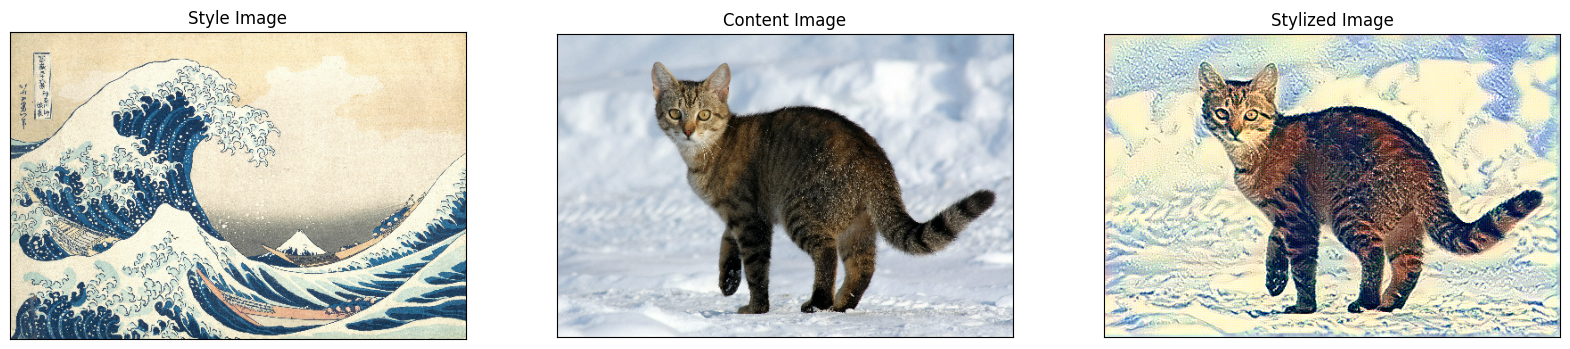

In [26]:
show_images([style_image, content_image, stylized_image_1], titles=['Style Image', 'Content Image', 'Stylized Image'])

### **Example 02**

In [ ]:
content_path = '/content/content_panda.jpeg'
style_path = '/content/style_crack.jpg'

content_image = load_img(content_path)
style_image = load_img(style_path)

style_weight =  1e-1
content_weight = 1e-32
var_weight = 0

adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.50
    )
)

stylized_image_2, display_images_2 = fit_style_transfer(style_image=style_image, content_image=content_image,
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=20, steps_per_epoch=100, var_weight=var_weight,
                                                    show_transition=False)

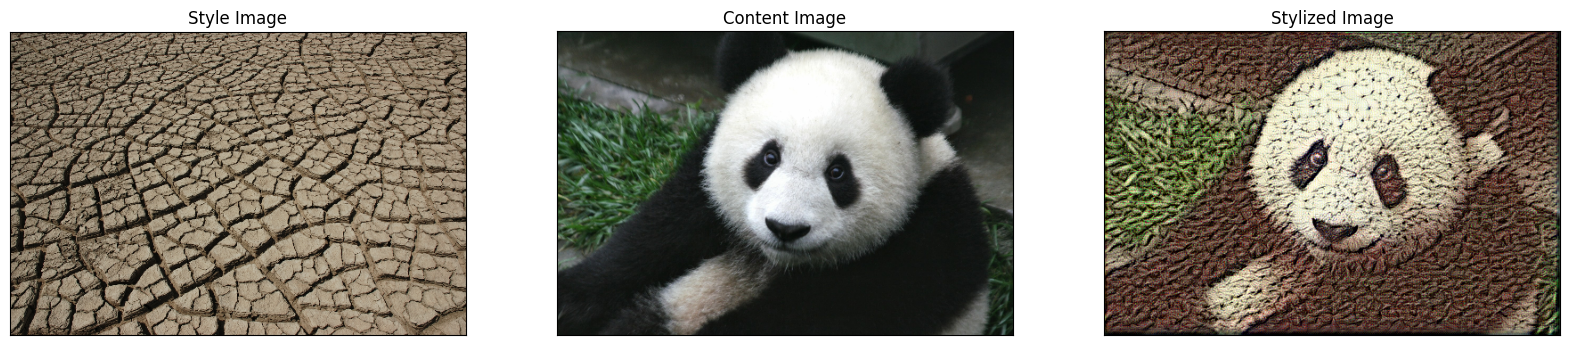

In [28]:
show_images([style_image, content_image, stylized_image_2], titles=['Style Image', 'Content Image', 'Stylized Image'])

**THANK YOU**

